# Imports

In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime

# Helper functions

In [2]:
conversion_rates = {
    'CHF': 1.14,  # 1 CHF = 1.134556 USD as of Feb 20, 2024, according to X-Rates
    'TRY': 0.032,   # 1 TRY = 0.03230 USD as of Feb 21, 2024, according to Wise
    'PLN': 0.25,  # 1 PLN = 0.250338 USD as of Feb 21, 2024, according to Xe.com
    'GBP': 1.26,      # Example rate, adjust with the actual rate when available
    'JOD': 1.41,      # Example rate, adjust with the actual rate when available
    'AUD' : 0.66,
    'BRL' : 0.2,
    'IDR' : 0.000064,
    'USD' : 1.0,
    'EUR' : 1.08,
    'ALL' : 0.010,
    'JPY' : 0.0066,
    'BDT' : 0.0091,
}



In [3]:
def convert_to_usd(row, price_col_name, currency_col_name):
    price = row[price_col_name]
    currency = row[currency_col_name]
    price = row['ticket_price']
    conversion_rate = conversion_rates.get(currency)

    # Check if conversion_rate is None
    if conversion_rate is None:
        # Handle the error (e.g., return 0, raise an exception, or use a default conversion rate)
        raise ValueError(f"Conversion rate for currency '{currency}' is not available.")
        # Alternatively, you can return 0 or some default value instead of raising an error
        # return 0
    
    return price * conversion_rate


In [4]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(fifth_element)
            else:
                try:
                    cleaned_lst.append(int(fifth_element))
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(0)
        else:
            cleaned_lst.append(0)  # If the list is too short, consider the fifth element as 0
    return cleaned_lst



In [5]:
def convert_list_to_datetime(date_list):
    # Convert 'null' strings to 0 and other elements to integers
    date_list = [0 if element == 'null' else int(element) for element in date_list]
    
    try:
        if len(date_list) == 5:
            # If all components are present, unpack the list directly into datetime
            return datetime(*date_list)
        elif len(date_list) == 4:
            # If the minute is missing (or any single component), append 0 for minutes and then convert
            return datetime(*(date_list + [0]))
        else:
            # Return None for lists of unexpected length to indicate an issue
            return None
    except TypeError:
        # Handle cases where the list contents cannot be directly unpacked into datetime
        return None




In [6]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(item[:4] + [fifth_element] + item[5:])
            else:
                try:
                    cleaned_lst.append(item[:4] + [int(fifth_element)] + item[5:])
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(item[:4] + [0] + item[5:])
        else:
            # If the list is too short, consider the fifth element as 0
            cleaned_lst.append(item[:4] + [0])
    return cleaned_lst



# Read and Clean Dataset

In [7]:
df = pd.read_csv('../data/3.raw_query_results/Query4_results_test.csv')

In [8]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(ast.literal_eval)

In [9]:
df['arrival_date'] = clean_fifth_element(df['arrival_date'])
df['departure_date'] = clean_fifth_element(df['departure_date'])

In [10]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(convert_list_to_datetime)

**Create identifier (FlightID) for identical flights**

In [11]:
df['Flight_ID'] = df[['airline_code', 'departure_airport_code', 'destination_airport_code','First_flight','last_flight_code','arrival_date','departure_date', 'departure_time','selling_airline','arrival_time','first_flight_code']].astype(str).agg('-'.join, axis=1)

In [12]:
df = df.drop(['departure_time','selling_airline','arrival_time'], axis = 1)

In [13]:
#df = df[df['Detected_Country'] != 'Shqipëri']


In [14]:
df.Detected_Country.value_counts()

Detected_Country
Polska                736
Schweiz               715
Indonesia             670
Türkiye               642
Deutschland           596
Australia             543
Shqipëri              536
Brasil                472
日本                    428
বাংলাদেশ              416
United Kingdom        358
Palestine             144
Vereinigte Staaten     84
Kıbrıs                 14
Name: count, dtype: int64

**Remove duplicates**

In [15]:
df["Duplicate_checker"] = df['Flight_ID'] + df['Detected_Country'] + df["Detected_Language"] + df["Detected_Country"] + str(df["ticket_price"])

In [16]:
df_reduced = df.drop_duplicates(subset='Duplicate_checker', keep='first').copy()

In [17]:
df_reduced = df_reduced.drop(['Duplicate_checker'], axis = 1)

**Remove NaN and erroneous rows**

In [18]:
df_reduced.dropna(subset=['Detected_Currency', 'ticket_price', 'Detected_Country'], inplace=True)

In [19]:
df_reduced = df_reduced[df_reduced['ticket_price'] >= 10]

# Feature engineering

In [20]:
df_reduced['Price_in_USD'] = df_reduced.apply(lambda row: convert_to_usd(row, 'ticket_price', 'Detected_Currency'), axis=1)

Creating commutime time

In [21]:
df_reduced['commute_time'] = (df_reduced['arrival_date'] - df_reduced['departure_date']).dt.total_seconds() / 60

In [22]:
df_reduced['query_date'] = pd.Timestamp('2024-02-15')

In [23]:
df_reduced['days_until_departure'] = (df_reduced['departure_date'] - df_reduced['query_date']).dt.days

**Eliminating queries with little country variance**

In [24]:
# Count the number of different countries available per Flight_ID
country_count_per_flight = df_reduced.groupby('Flight_ID')['Detected_Country'].nunique().reset_index(name='FlightID_in_Countries_Count')

# Merge this count back into the original dataframe
df_reduced = df_reduced.merge(country_count_per_flight, on='Flight_ID')


In [25]:
df_reduced = df_reduced[df_reduced['FlightID_in_Countries_Count'] >= 8]

**Creating Journey_ID: Identifier for identical journeys (same departure and destination airport) on same days**

Extracting departure and arrival days

In [26]:
df_reduced["departure_date_day"] = df_reduced["departure_date"].dt.strftime('%d-%m-%Y')
df_reduced["arrival_date_day"] = df_reduced["arrival_date"].dt.strftime('%d-%m-%Y')

Creating column for whole Journey

In [27]:
df_reduced["Journey_route"] = df_reduced["departure_airport_code"] + "-" + df_reduced["destination_airport_code"]

In [28]:
df_reduced["Journey_ID"] = df_reduced["Journey_route"] + ": " + df_reduced["departure_date_day"] + " "  + df_reduced["arrival_date_day"]

**Creating Variables that analyse price differences between identical Flights**

In [29]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats = df_reduced.groupby('Flight_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats['max_price_diff_FlightID'] = price_stats['max'] - price_stats['min']
price_stats.columns = ['max_price_FlightID', 'min_price_FlightID', 'max_price_diff_FlightID']
# Calculate the relative difference as a percentage of the min price
price_stats['max_rel_price_diff_FlightID'] = (price_stats['max_price_diff_FlightID'] / price_stats['min_price_FlightID']) * 100

In [30]:
df_reduced = pd.merge(df_reduced, price_stats, on='Flight_ID', how='left')

In [31]:
df_reduced["abs_diff_to_min_price_FlightID"] = df_reduced["Price_in_USD"] - df_reduced["min_price_FlightID"]
df_reduced["rel_diff_to_min_price_FlightID"] = ((df_reduced["Price_in_USD"] /df_reduced["min_price_FlightID"] ) -1) * 100
df_reduced['rel_price_score_FlightID'] = df_reduced['rel_diff_to_min_price_FlightID'] / df_reduced['max_rel_price_diff_FlightID']

**Creating Variables that analyse price differences between identical Journey**

In [32]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats_journey = df_reduced.groupby('Journey_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats_journey['max_abs_diff_JourneyID'] = price_stats_journey['max'] - price_stats_journey['min']
price_stats_journey.columns = ['max_price_JourneyID', 'min_price_JourneyID', 'max_abs_diff_JourneyID']
price_stats_journey['max_rel_diff_Journey'] = (price_stats_journey['max_abs_diff_JourneyID'] / price_stats_journey['min_price_JourneyID']) * 100

In [33]:
df_reduced = pd.merge(df_reduced, price_stats_journey, on='Journey_ID', how='left')

In [34]:
df_reduced["abs_diff_to_min_price_JourneyID"] = df_reduced["Price_in_USD"] - df_reduced["min_price_JourneyID"]
df_reduced["rel_diff_to_min_price_JourneyID"] = ((df_reduced["Price_in_USD"] /df_reduced["min_price_JourneyID"] ) -1) * 100
df_reduced['rel_price_score_JourneyID'] = df_reduced['rel_diff_to_min_price_JourneyID'] / df_reduced['max_rel_diff_Journey']

**Creating Variables that analyse price differences between identical Journey within the same query-country**

In [35]:
price_stats_journey_same_country = df_reduced.groupby(['Journey_ID', 'Detected_Country'])['Price_in_USD'].agg(['max', 'min'])
price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] = price_stats_journey_same_country['max'] - price_stats_journey_same_country['min']
price_stats_journey_same_country.columns = ['max_journey_same_country', 'min_journey_same_country', 'max_abs_diff_perIDGroup_Journey_same_country']
price_stats_journey_same_country['max_rel_diff_perIDGroup_Journey_same_country'] = (price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] / price_stats_journey_same_country['min_journey_same_country']) * 100

In [36]:
df_reduced = pd.merge(df_reduced, price_stats_journey_same_country, on=['Journey_ID','Detected_Country'], how='left')

In [37]:
df_reduced["price_diff_loc_to_glob_Journey_min"] = df_reduced["min_journey_same_country"] - df_reduced["min_price_JourneyID"]
df_reduced["rel_price_diff_loc_to_glob_Journey_min"] = (df_reduced["price_diff_loc_to_glob_Journey_min"] / df_reduced["min_price_JourneyID"]) * 100

In [38]:
# Group by 'Detected_Country' and calculate the mean of 'rel_price_diff_loc_to_glob_Journey_min'
grouped_means = df_reduced.groupby('Detected_Country')['rel_price_diff_loc_to_glob_Journey_min'].mean()

# Display the result
print(grouped_means)


Detected_Country
Australia              7.035948
Brasil                 3.084377
Deutschland            3.859205
Indonesia              3.959648
Palestine              4.120533
Polska                 3.835188
Schweiz                4.383528
Shqipëri               0.358481
Türkiye                3.597201
United Kingdom         7.392782
Vereinigte Staaten     4.479632
বাংলাদেশ               3.802642
日本                    17.559797
Name: rel_price_diff_loc_to_glob_Journey_min, dtype: float64


In [39]:
(price_stats_journey_same_country['max_abs_diff_perIDGroup_Journey_same_country'] / price_stats_journey_same_country['min_journey_same_country']) * 100

Journey_ID                      Detected_Country
BWI-LUX: 26-02-2024 27-02-2024  Australia           10.514983
                                Brasil              10.526606
                                Deutschland         10.506067
                                Indonesia           10.525340
                                Polska              10.524152
                                                      ...    
ZAG-NRT: 05-11-2024 07-11-2024  Polska               0.000000
                                Schweiz              0.000000
                                Shqipëri             0.000000
                                Türkiye              0.000000
                                বাংলাদেশ             0.000000
Length: 565, dtype: float64

In [40]:

# Step 1: Filter to get rows where Price_in_USD equals the min for each Journey_ID
cheapest_mask_journey = df_reduced['Price_in_USD'] == df_reduced['min_price_JourneyID']
cheapest_journeys = df_reduced[cheapest_mask_journey]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations_journey = cheapest_journeys.groupby('Journey_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations_journey.rename(columns={'Detected_Country': 'Cheapest_Location_Journey'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations_journey, on='Journey_ID', how='left')



In [41]:
df_reduced.Cheapest_Location_Journey.value_counts()

Cheapest_Location_Journey
Shqipëri          2054
Brasil             242
日本                 220
United Kingdom      10
Name: count, dtype: int64

In [42]:

# Step 1: Filter to get rows where Price_in_USD equals the min for each Flight_ID
cheapest_mask = df_reduced['Price_in_USD'] == df_reduced['min_price_FlightID']
cheapest_flights = df_reduced[cheapest_mask]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations = cheapest_flights.groupby('Flight_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations.rename(columns={'Detected_Country': 'Cheapest_Location_Flight'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations, on='Flight_ID', how='left')

In [43]:
cheapest_flights = df_reduced[df_reduced['Price_in_USD'] == df_reduced['min_price_FlightID']]

In [44]:
unique_flight_ids = cheapest_flights['Flight_ID'].nunique()
total_rows = cheapest_flights.shape[0]

if unique_flight_ids == total_rows:
    print("Each min_price_FlightID identifies a unique row per Flight_ID.")
else:
    print(f"Some Flight_IDs have multiple rows with the same minimum price. Unique Flight IDs: {unique_flight_ids}, Total Rows: {total_rows}")


Each min_price_FlightID identifies a unique row per Flight_ID.


In [45]:
df_reduced.Cheapest_Location_Flight.value_counts()

Cheapest_Location_Flight
Shqipëri          2167
Brasil             259
日本                  90
United Kingdom      10
Name: count, dtype: int64

# Adjust FLIGHTID so it incorporates the query_date!!! Both in this notebook and in preprocce pipeline!! Same for JourneyID

# Creating Main Variables for Prediction

In [46]:
# Calculate the average of rel_diff_to_min_price_FlightID for each Journey_ID and Detected_Country
average_savings_journeyID = df_reduced.groupby(['Journey_ID', 'Detected_Country'])['rel_diff_to_min_price_FlightID'].mean().reset_index(name='average_savings_for_JourneyID_in_Detected_Country')
# Merge the average_savings DataFrame back into df_reduced
df_reduced = df_reduced.merge(average_savings_journeyID, on=['Journey_ID', 'Detected_Country'], how='left')

In [47]:
# Calculate the average of rel_diff_to_min_price_FlightID for each Journey_ID and Detected_Country
average_savings_route = df_reduced.groupby(['Journey_route', 'Detected_Country'])['rel_diff_to_min_price_FlightID'].mean().reset_index(name='average_savings_for_Journey_route_in_Detected_Country')
# Merge the average_savings DataFrame back into df_reduced
df_reduced = df_reduced.merge(average_savings_route, on=['Journey_route', 'Detected_Country'], how='left')


In [48]:
average_savings_route.sort_values(by ='average_savings_for_Journey_route_in_Detected_Country', ascending=False)
with pd.option_context('display.max_rows', None):
    display(average_savings_route.sort_values(by='average_savings_for_Journey_route_in_Detected_Country', ascending=False))

,Journey_route,Detected_Country,average_savings_for_Journey_route_in_Detected_Country
167,LAX-LIS,Australia,169.333250
174,LAX-LIS,United Kingdom,167.108877
176,LAX-LIS,日本,110.472990
277,PHX-CGH,Australia,38.142586
285,PHX-CGH,United Kingdom,36.971422
214,MAN-CPT,Australia,24.500556
222,MAN-CPT,United Kingdom,23.449690
219,MAN-CPT,Schweiz,7.674696
217,MAN-CPT,Indonesia,7.318396
223,MAN-CPT,বাংলাদেশ,7.142469


**Creating a variable for the Cheapest_Location for a route**

In [49]:
cheapest_location_counts = df_reduced.groupby(['Journey_route', 'Detected_Country', 'Cheapest_Location_Flight']).size().reset_index(name='count_cheapest_location')
# Ensure a randomized selection in case of ties by shuffling
cheapest_location_counts = cheapest_location_counts.sample(frac=1).reset_index(drop=True)
cheapest_location_counts_sorted = cheapest_location_counts.sort_values(['Journey_route', 'Detected_Country', 'count_cheapest_location'], ascending=[True, True, False])
top_cheapest_location = cheapest_location_counts_sorted.groupby(['Journey_route', 'Detected_Country']).first().reset_index()
top_cheapest_location["Mode_Cheapest_Location_Journey"] = top_cheapest_location["Cheapest_Location_Flight"]

In [50]:
df_reduced = df_reduced.merge(top_cheapest_location[['Journey_route', 'Detected_Country', 'Mode_Cheapest_Location_Journey']], on=['Journey_route', 'Detected_Country'], how='left')

# Test new features

In [51]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'commute_time', 'query_date', 'days_until_departure',
       'FlightID_in_Countries_Count', 'departure_date_day', 'arrival_date_day',
       'Journey_route', 'Journey_ID', 'max_price_FlightID',
       'min_price_FlightID', 'max_price_diff_FlightID',
       'max_rel_price_diff_FlightID', 'abs_diff_to_min_price_FlightID',
       'rel_diff_to_min_price_FlightID', 'rel_price_score_FlightID',
       'max_price_JourneyID', 'min_price_JourneyID', 'max_abs_diff_JourneyID',
       'max_rel_diff_Journey', 'abs_diff_to_min_price_JourneyID',
       'rel_diff_to_min_price_JourneyID', 'rel_price_score_JourneyID',
       'max_journey_same_country', 'min_journey_same_country',
       'max_abs_diff_perIDG

# Descriptive Statistics

**_These countries are connected with higher Prices for identical flights_**

In [52]:
temp_df_exp = df_reduced[df_reduced['rel_price_score_FlightID'] > 0.8]
temp_df_exp.Detected_Country.value_counts()

Detected_Country
Schweiz               266
Australia             222
Indonesia             197
Polska                185
বাংলাদেশ              164
Deutschland           162
United Kingdom         89
Palestine              87
Vereinigte Staaten     47
Türkiye                39
Brasil                  2
日本                      1
Name: count, dtype: int64

**_These countries are connected with lower prices for identical flights_**

In [53]:
temp_df_cheap = df_reduced[(df_reduced['max_rel_price_diff_FlightID'] > 4.5) & (df_reduced['rel_price_score_FlightID'] < 0.2)]
temp_df_cheap.Detected_Country.value_counts()

Detected_Country
Shqipëri          203
Polska              8
Türkiye             8
বাংলাদেশ            8
Brasil              8
Indonesia           6
Schweiz             6
Deutschland         4
日本                  1
United Kingdom      1
Australia           1
Name: count, dtype: int64

Distribution shows tendency of having more "expensive" flights (flights close to max-price) and less variation in general

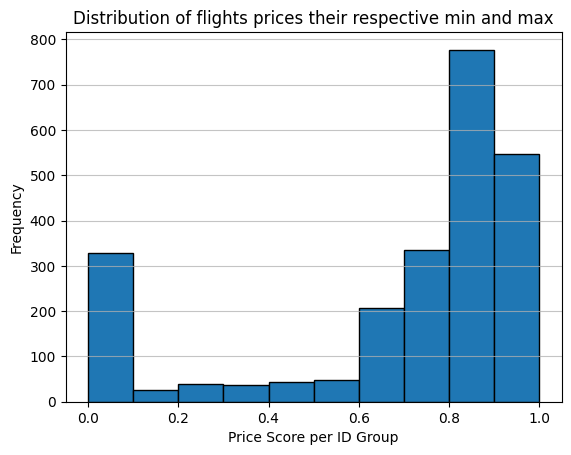

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_reduced is your DataFrame
# Plotting the histogram
df_reduced['rel_price_score_FlightID'].plot.hist(bins=10, range=(0, 1), edgecolor='black')

plt.title('Distribution of flights prices their respective min and max')
plt.xlabel('Price Score per ID Group')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for better readability

plt.show()

** Average indicates that the average maximum relative difference increases with Price**

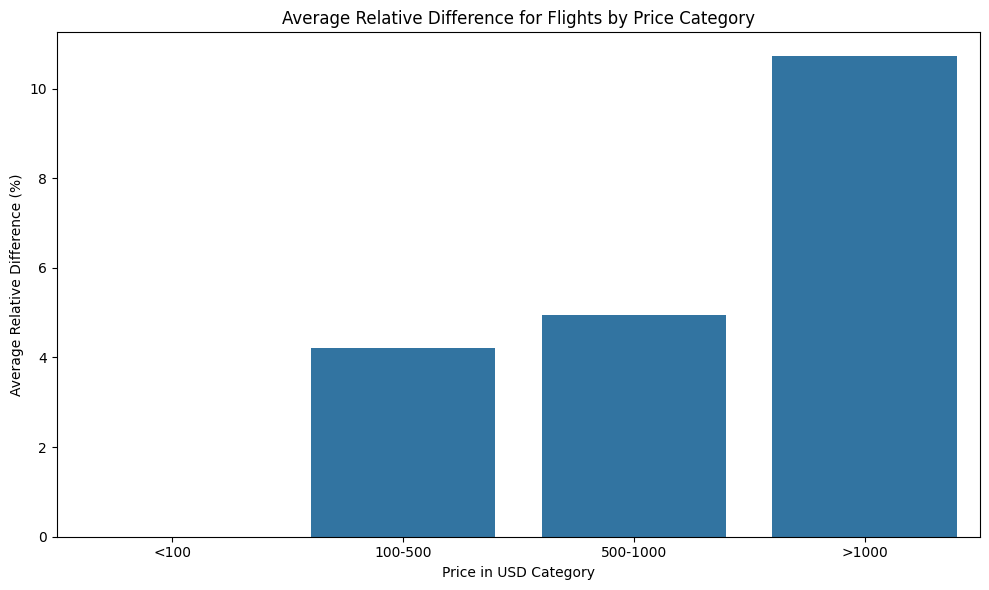

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_price_diff_FlightID'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_price_diff_FlightID')
plt.title('Average Relative Difference for Flights by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


** Median doesnt show this effect **

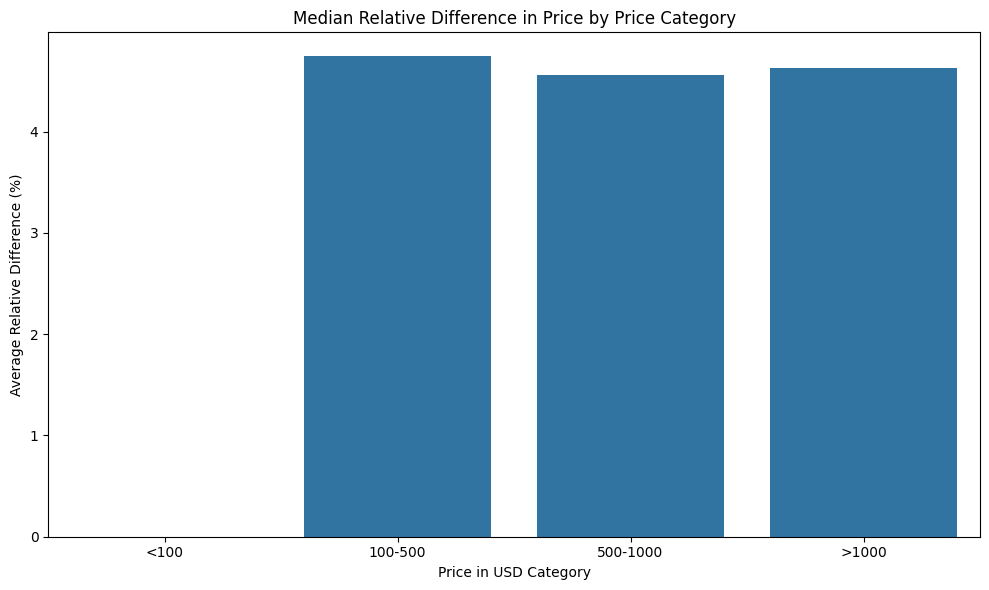

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_price_diff_FlightID'].median().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_price_diff_FlightID')
plt.title('Median Relative Difference in Price by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()

**The average price spread grows with commute time**

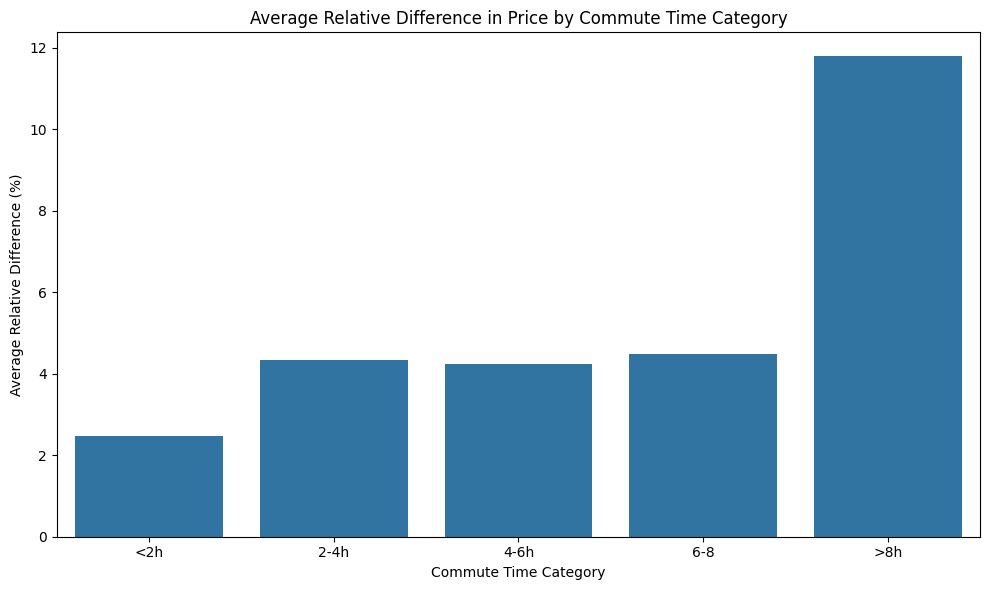

In [57]:
# Adjust bins based on the new categories in minutes
bins = [-float('inf'), 120, 240, 480,750, float('inf')]
labels = ['<2h', '2-4h', '4-6h','6-8' ,'>8h']

# Bin 'commute_time' into categories directly, no need to convert to hours since it's already in minutes
df_reduced['Commute_Time_Category'] = pd.cut(df_reduced['commute_time'], bins=bins, labels=labels)

# Group by the new 'Commute_Time_Category' and calculate the mean 'max_rel_diff_perIDGroup' for each category
avg_rel_diff_by_commute_cat = df_reduced.groupby('Commute_Time_Category', observed = True)['max_rel_price_diff_FlightID'].mean().reset_index()

# Plotting the average relative difference by commute time category
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_commute_cat, x='Commute_Time_Category', y='max_rel_price_diff_FlightID')
plt.title('Average Relative Difference in Price by Commute Time Category')
plt.xlabel('Commute Time Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


**Most Airlines seem to have an average price-spread in between of 3.5 and 4.5**

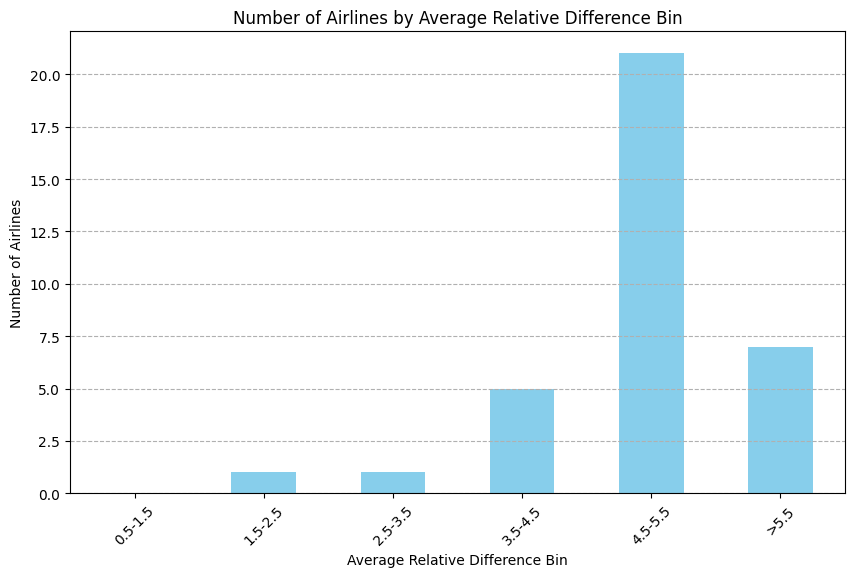

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the conditional mean of 'rel_diff' for each airline
avg_rel_diff_per_airline = df_reduced.groupby('airline_code', observed=True)['max_rel_price_diff_FlightID'].mean().reset_index()

# Define bins and labels for the categorized means
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, float('inf')]
labels = [ '0.5-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5.5', '>5.5']

# Step 2: Categorize these averages into the specified bins
avg_rel_diff_per_airline['avg_rel_diff_bin'] = pd.cut(avg_rel_diff_per_airline['max_rel_price_diff_FlightID'], bins=bins, labels=labels)

# Step 3: Count how many airlines fall into each bin
airlines_per_bin = avg_rel_diff_per_airline['avg_rel_diff_bin'].value_counts().sort_index()

# Plotting the result
airlines_per_bin.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Airlines by Average Relative Difference Bin')
plt.xlabel('Average Relative Difference Bin')
plt.ylabel('Number of Airlines')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


**Which airlines change their prices based on location**

In [59]:
# Group airlines by their average 'rel_diff' bin
grouped_airlines = avg_rel_diff_per_airline.groupby('avg_rel_diff_bin')['airline_code'].apply(list)

# Convert to a DataFrame for a nicer display, if desired
grouped_airlines_df = grouped_airlines.reset_index().rename(columns={'airline_code': 'Airlines'})


# Display the DataFrame
print(grouped_airlines_df)


  avg_rel_diff_bin                                           Airlines
0          0.5-1.5                                                 []
1          1.5-2.5                                               [XE]
2          2.5-3.5                                               [DL]
3          3.5-4.5                               [AS, LA, LH, TK, TP]
4          4.5-5.5  [AA, AF, AM, AV, AZ, BA, BR, CM, CX, F9, JL, L...
5             >5.5                    [AC, EK, IB, KL, QR, UA, multi]


In [60]:
avg_rel_diff_per_airline

,airline_code,max_rel_price_diff_FlightID,avg_rel_diff_bin
0,AA,4.921051,4.5-5.5
1,AC,64.734473,>5.5
2,AF,4.999096,4.5-5.5
3,AM,4.637533,4.5-5.5
4,AS,3.502412,3.5-4.5
5,AV,4.542922,4.5-5.5
6,AZ,4.604290,4.5-5.5
7,BA,4.566377,4.5-5.5
8,BR,4.643414,4.5-5.5
9,CM,4.625982,4.5-5.5


Which countries are the cheapest?

In [61]:
import xgboost

In [62]:
cheap_df = df_reduced[(df_reduced['min_price_FlightID'] == df_reduced['Price_in_USD'] )]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = cheap_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Shqipëri          245
Brasil             32
日本                 11
United Kingdom      1
Name: count, dtype: int64


**Which countries are more expensive**

In [63]:

expensive_df = df_reduced[(df_reduced['max_price_FlightID'] == df_reduced['Price_in_USD'])]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = expensive_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Australia             192
Schweiz                75
Palestine              13
Vereinigte Staaten      9
Name: count, dtype: int64


# Statistical Testing

In [64]:
from scipy.stats import f_oneway

# Assuming 'flight_data' is your DataFrame containing flight information
# 'Price' is the column containing flight prices, and 'Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries.")


ANOVA results:
F-statistic: 700.3148669078242
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries.


In [65]:
from scipy.stats import f_oneway

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Assigned_Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries for the same flight route.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries for the same flight route.")


ANOVA results:
F-statistic: 700.3148669078242
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries for the same flight route.


In [66]:
from scipy.stats import ttest_rel

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Flight_ID' is the column containing flight identifiers

# Group the data by Flight_ID and calculate the maximum and minimum prices for each group
max_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].max()
min_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].min()

# Perform paired samples t-test
t_statistic, p_value = ttest_rel(max_prices, min_prices)

# Interpret the results
alpha = 0.05  # Significance level
print("Paired samples t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.")
else:
    print("There is no statistically significant difference between the maximum and minimum prices of each Flight_ID.")


Paired samples t-test results:
t-statistic: 5.184409370380557
p-value: 4.087471333332363e-07
There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.


# Creating Model v1 with 80% of Batch1

Predicting average price spread  

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb  # corrected import statement
from sklearn.metrics import mean_absolute_error  # corrected import for regression metrics

# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country','Detected_Currency']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']  # remove get_dummies for y

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)  # corrected variable name for fitting

# Predict and evaluate
y_pred = xgb_model.predict(X_test)  # corrected variable name for prediction
# Evaluation metrics for regression
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Mean Absolute Error: 0.0064128597599112215


Predicting Cheapest Country Location 

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route','days_until_departure','Detected_Country']], drop_first=True)
y = pd.get_dummies(df_reduced['Cheapest_Location_Flight'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=71)

# Create and fit the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Adjust model parameters as needed
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
# Evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
# ROC-AUC can be computed for binary classification, and for multi-class, strategies like One-vs-Rest need to be applied.
# Depending on your y structure, you might need to adapt the ROC AUC computation.
# print(f"ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')}")


Accuracy: 0.9881422924901185
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.99      1.00      0.99       221
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         9

   micro avg       0.99      0.99      0.99       253
   macro avg       0.75      0.74      0.74       253
weighted avg       0.98      0.99      0.98       253
 samples avg       0.99      0.99      0.99       253



# Creating model v1 with 100% data from 1.Batch and test on all data from 2.Batch

## Fit model 

In [69]:
# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['Journey_route', 'days_until_departure', 'Detected_Country','Detected_Currency']], drop_first=True)
y = df_reduced['average_savings_for_Journey_route_in_Detected_Country']

# Specify your model parameters here
params = {'colsample_bytree': 0.9, 'eta': 0.299, 'max_depth': 7, 'subsample': 0.8}
params_optuna = {'max_depth': 7, 'eta': 0.319923163390001, 'subsample': 0.8, 'colsample_bytree': 0.9}

# Create XGBoost model
model_v1 = xgb.XGBRegressor(**params_optuna)

feature_names = X.columns.tolist()

# Proceed with model training as you've done
model_v1.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.319923163390001, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## Predict on test set from 2.Batch

In [70]:
from sklearn.metrics import mean_absolute_error, r2_score



# Load and prepare test data
df_test = pd.read_csv("../data/4.processed_data/Query1503_results_conv_processed.csv")
X_test = pd.get_dummies(df_test[['Journey_route', 'days_until_departure', 'Detected_Country', 'Detected_Currency']], drop_first=True)
y_test = df_test['average_savings_for_Journey_route_in_Detected_Country']

# Ensure `X_test` columns are in the same order as the training dataset
X_test = X_test.reindex(columns=feature_names)

# Now, predict with `X_test` which has the columns ordered as per the model's training
y_pred = model_v1.predict(X_test)

# Calculate and print the Mean Squared Error
mea = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mea}")


r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Mean Absolute Error: 8.045070631696717
R-squared: -33.86595018110855


# Creating model_v2_combined with 80& data from 1.Batch and 2.Batch

In [71]:
combined_df = pd.concat([df_reduced, df_test], ignore_index=True)

In [73]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(combined_df[['Journey_route','days_until_departure','Detected_Country','Detected_Currency']])
y = combined_df['average_savings_for_Journey_route_in_Detected_Country']

# Now proceed with the splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Specify your model parameters here
params_grid = {'colsample_bytree': 0.9, 'eta': 0.299, 'max_depth': 7, 'subsample': 0.8}
params_optuna = {'max_depth': 7, 'eta': 0.319923163390001, 'subsample': 0.8, 'colsample_bytree': 0.9}

# Create XGBoost model
model_v2_combined  = xgb.XGBRegressor(**params_optuna)

# Fit the model on your training data
model_v2_combined.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.319923163390001, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Evaluting test accuracy

In [ ]:
predictions = model_v2_combined.predict(X_test)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")


r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")


Mean Absolute Error: 0.1564308457420991
R-squared: 0.9639458691628248
